In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

In [2]:
# Read the libraries into data rames
private = pd.read_csv('private_ev_charging.csv')
public = pd.read_csv('public_ev_charging.csv')
sales = pd.read_csv('ev_sales.csv')

In [3]:
# High level exploratory analysis
for i in (private,public,sales):
    print(i.info())
    print(i.describe())
    print(i.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   year                       9 non-null      int64
 1   private_ports              9 non-null      int64
 2   private_station_locations  9 non-null      int64
dtypes: int64(3)
memory usage: 344.0 bytes
None
              year  private_ports  private_station_locations
count     9.000000       9.000000                   9.000000
mean   2018.000000    9547.777778                2814.666667
std       2.738613    6070.143836                 903.266572
min    2014.000000    3695.000000                1825.000000
25%    2016.000000    5763.000000                2331.000000
50%    2018.000000    6812.000000                2489.000000
75%    2020.000000   10647.000000                3078.000000
max    2022.000000   19993.000000                4435.000000
year                         0
pr

In [4]:
# Examining if there are any duplicated values
for dup in (private,public,sales):
    print(dup[dup.duplicated()])

Empty DataFrame
Columns: [year, private_ports, private_station_locations]
Index: []
Empty DataFrame
Columns: [year, public_ports, public_station_locations]
Index: []
Empty DataFrame
Columns: [Vehicle, year, sales]
Index: []


            Vehicle  year  sales
34  Mitsubishi I EV  2018    NaN
35  Mitsubishi I EV  2019    NaN
36     BMW Active E  2011    NaN
38     BMW Active E  2013    NaN
39     BMW Active E  2014    NaN
40     BMW Active E  2015    NaN
41     BMW Active E  2016    NaN
42     BMW Active E  2017    NaN
43     BMW Active E  2018    NaN
44     BMW Active E  2019    NaN
            Vehicle  year   sales
27  Mitsubishi I EV  2011    76.0
28  Mitsubishi I EV  2012   588.0
29  Mitsubishi I EV  2013  1029.0
30  Mitsubishi I EV  2014   196.0
31  Mitsubishi I EV  2015   115.0
32  Mitsubishi I EV  2016    94.0
33  Mitsubishi I EV  2017     6.0
34  Mitsubishi I EV  2018     NaN
35  Mitsubishi I EV  2019     NaN


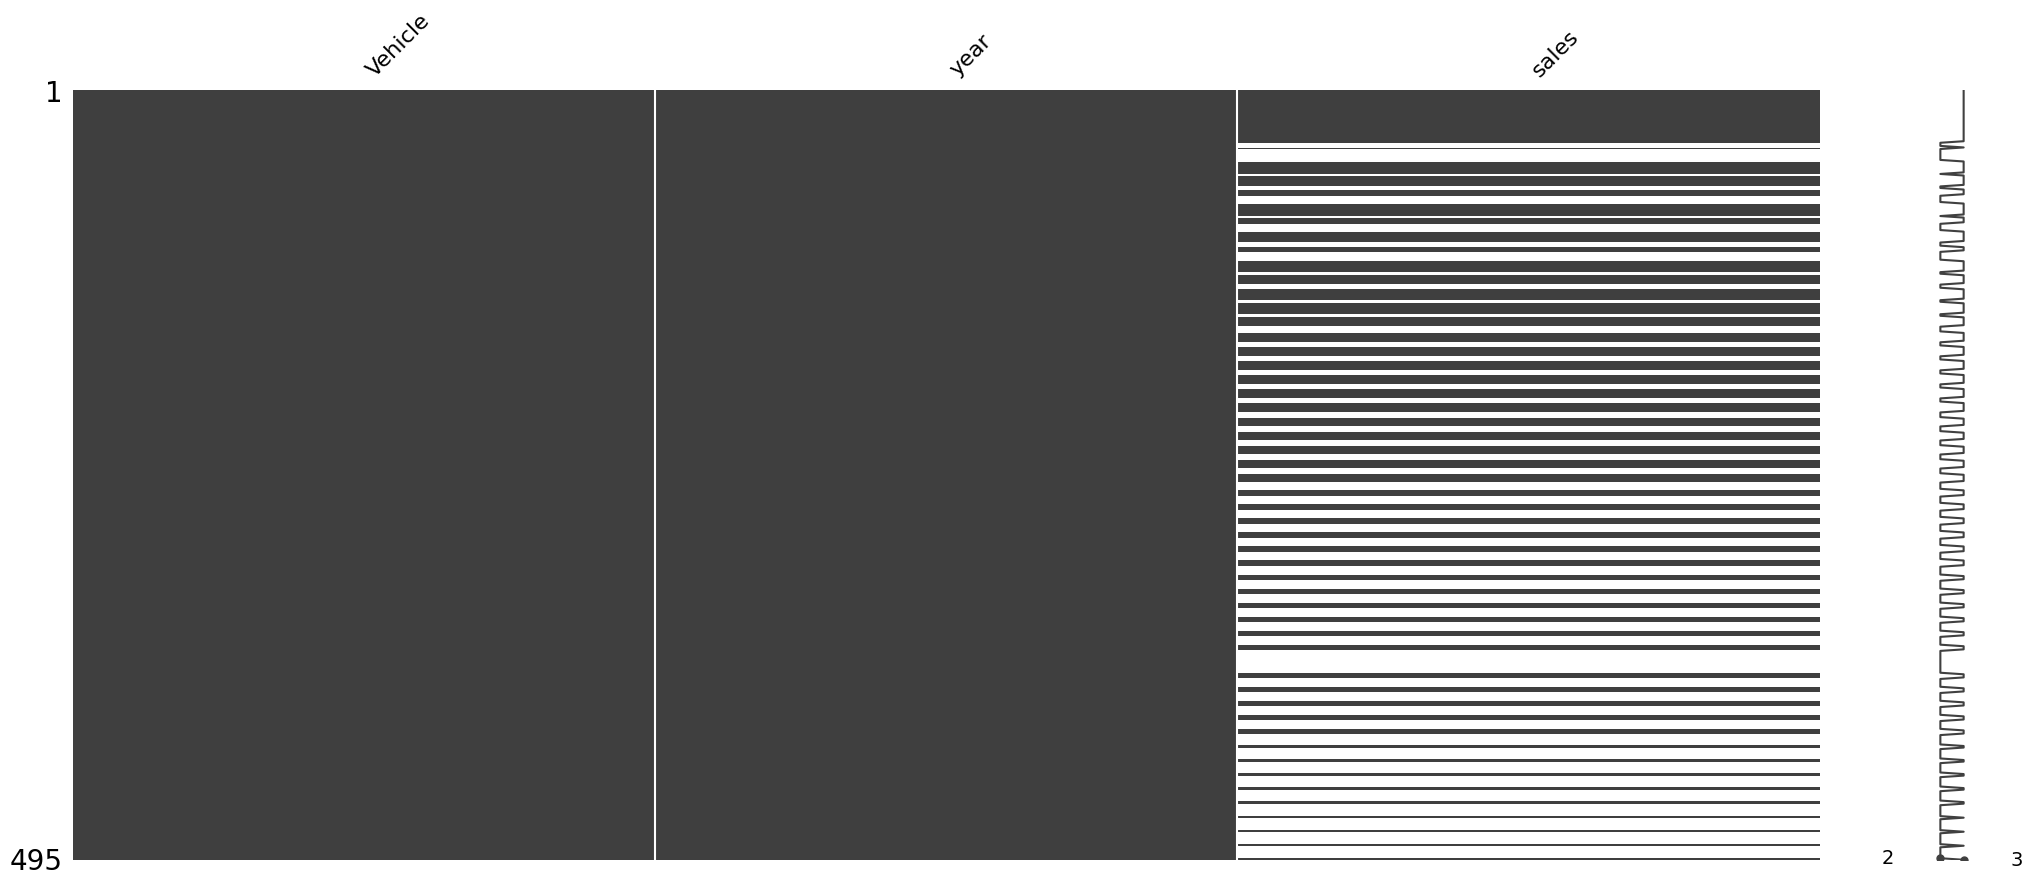

                                  count_sales  count_missing_values
Vehicle                                                            
Audi A3 Plug In                             4                     5
Audi e-tron                                 1                     8
BMW 3-series Plug-In                        4                     5
BMW 5-Series Plug in                        3                     6
BMW 7-series Plug-in                        4                     5
BMW Active E                                1                     8
BMW X5                                      5                     4
BMW i3                                      6                     3
BMW i8                                      6                     3
Cadillac CT6                                3                     6
Cadillac ELR                                6                     3
Chevy Bolt                                  4                     5
Chevy Spark                                 6   

In [5]:
# Examine missing values pattern in sales column since roughly 50% of the entries are missing
import missingno as msno

print(sales[sales['sales'].isna()].head(10))
print(sales[sales['Vehicle']=='Mitsubishi I EV'])

# Visualise the missing values

msno.matrix(sales)
plt.show()

# Group missing values per car to examine missing values distribution
grouped_missing = sales.groupby('Vehicle').agg(
                                               count_sales = ('sales', lambda x: x.notna().sum()),
                                               count_missing_values = ('sales', lambda x: x.isna().sum())
                                              )
print(grouped_missing)


In [6]:
# Impute missing values to 0 as they represent years w/o models sales

sales['sales'] = sales['sales'].fillna(0)
print(sales.isna().sum())

Vehicle    0
year       0
sales      0
dtype: int64


In [7]:
# Group the sales dataframe on years with sum in order to merge it with the other dataframes

sales_grouped = sales.groupby('year')['sales'].agg(sum).reset_index()
print(sales_grouped)

# Pull sales on 2018 per project question

ev_sales_2018 = sales_grouped[sales_grouped['year']==2018]['sales'].values[0]

print(f"In 2018 {ev_sales_2018} EVs were sold")

   year     sales
0  2011   17763.0
1  2012   53171.0
2  2013   97102.0
3  2014  118882.0
4  2015  114023.0
5  2016  159616.0
6  2017  195581.0
7  2018  361315.0
8  2019  326644.0
In 2018 361315.0 EVs were sold


In [21]:
# Merge the 3 dataframes on the year column

df = public.merge(private, on = 'year', how='left')\
                  .merge(sales_grouped, on = 'year', how = 'outer', suffixes=['_private','_sales'])\
                  .sort_values(by='year')

df.reset_index(drop=True,inplace=True)

print(df)


    year  public_ports  public_station_locations  private_ports  \
0   2011           NaN                       NaN            NaN   
1   2012           NaN                       NaN            NaN   
2   2013       16619.0                    6938.0            NaN   
3   2014       22470.0                    9207.0         3695.0   
4   2015       26532.0                   10710.0         4150.0   
5   2016       33165.0                   13150.0         5763.0   
6   2017       45789.0                   16170.0         6048.0   
7   2018       56842.0                   19893.0         6812.0   
8   2019       73838.0                   23282.0         9955.0   
9   2020       96190.0                   28602.0        10647.0   
10  2021      114451.0                   46407.0        18867.0   
11  2022      136513.0                   53764.0        19993.0   

    private_station_locations     sales  
0                         NaN   17763.0  
1                         NaN   53171.0  
2 

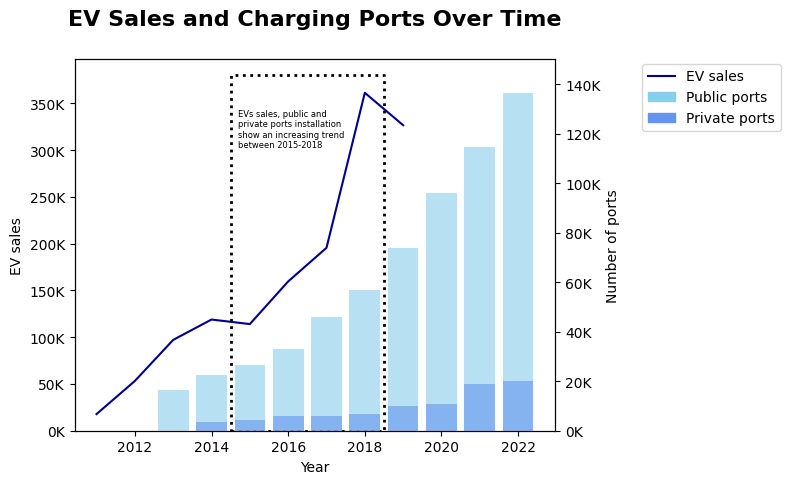

In [10]:
# Plot trends of sales, private and public ports with Matplotlib

fig,ax = plt.subplots()

# Set title
fig.suptitle('EV Sales and Charging Ports Over Time', fontsize=16, fontweight='bold', y=1)

# Plot 1 - sales (line)
line_plot = ax.plot(df['year'],df['sales'], color='darkblue', label='EV sales')
ax.set_xlabel('Year')
ax.set_ylabel('EV sales', color = 'black')

# Plot 2+3 - ports with different y axis due to different scale from sales
ax2 = ax.twinx()
bar_plot1 = ax2.bar(df['year'], df['public_ports'], color='skyblue', alpha=0.6, label='Public ports')
bar_plot2 = ax2.bar(df['year'], df['private_ports'], \
                   color='cornflowerblue', alpha=0.6, label='Private ports')
ax2.set_ylabel('Number of ports', color='black')

# Align the 0 for both y axes
ax.set_ylim(0, df['sales'].max() * 1.1) 
ax2.set_ylim(0, max(df['public_ports'].max(), df['private_ports'].max()) * 1.1)


# Adjust the y axes to K

def custom_formatter(x, pos):
    return f'{x * 1e-3:.0f}K'

ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(custom_formatter))


# Implement a legend
handles, labels = [], []
handles.append(line_plot[0]) 
labels.extend(['EV sales'])

handles.append(Patch(color='skyblue', label='Public ports'))
labels.append('Public ports')

handles.append(Patch(color='cornflowerblue', label='Private ports'))
labels.append('Private ports')

fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.9), ncol=1)
plt.tight_layout()

# Implement a dotted rectangle to highlight the data asked in the question
corner1 = (2014.5, 0)
corner2 = (2018.5, 0)
corner3 = (2018.5, 380000)
corner4 = (2014.5, 380000)

x_coords = [corner1[0], corner2[0], corner3[0], corner4[0], corner1[0]]
y_coords = [corner1[1], corner2[1], corner3[1], corner4[1], corner1[1]]

ax.plot(x_coords, y_coords, linestyle='dotted', color='black',linewidth=2)

# Add a findings text
summary_text = """
EVs sales, public and 
private ports installation 
show an increasing trend 
between 2015-2018
"""

fig.text(0.38, 0.75, summary_text, ha='left', va='center', fontsize=6)

plt.show()

# The EVs sales and ports installation trends are increaing between 2015-2018 